# 1. Setup

## 1.A Summary

### <span style="color: #2E86AB;">**Initial Setup and Data Loading**</span>

This notebook establishes the foundation for analysing student dropout prediction using machine learning techniques.

### <span style="color: #2E86AB;">**Key Components**</span>
- **Configuration Management**: Loads settings from `config.toml` using `tomllib`
- **Data Import**: Imports essential libraries for data analysis (`pandas`, `numpy`), visualisation (`matplotlib`, `seaborn`), and statistical analysis (`statsmodels`)
- **Dataset Loading**: Loads the "Predict Students' Dropout and Academic Success" dataset from UCI ML Repository
- **Data Source**: CSV file with semicolon delimiter containing student demographic and academic performance data

### <span style="color: #2E86AB;">**Dataset Reference:**</span>
Realinho, V., Martins, M.V., Machado, J. and Baptista, L.M.T., 2021. *Predict Students' Dropout and Academic Success*. UCI Machine Learning Repository.

## 1.B Libraries Import

In [362]:
# Standard library
from pathlib import Path

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rich import print
from scipy.stats import chi2_contingency, pointbiserialr
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Local modules
from tools import Tools


## 1.C Invoke Classes

In [363]:
# Invoke classes
tools = Tools()

## 1.D Load Configuation

In [364]:
config = tools.load_toml_file('config.toml')
tools.print_message('success', 'Loaded configuration', format_dict={'number of keys': len(config)})

>>> ✅ SUCCESS!: Loaded configuration NUMBER OF KEYS: 5

## 1.E Load Raw Dataset

Source: Realinho, V., Martins, M.V., Machado, J. and Baptista, L.M.T., 2021. Predict Students' Dropout and Academic Success. UCI Machine Learning Repository. Available at: https://doi.org/10.24432/C5MC89 [Accessed 31 May 2025].


In [365]:
# Open dataset
# Get path to datasets folder using modern pathlib syntax
dataset_path = Path.cwd() / 'datasets' / 'dataset_raw.csv'

# Check if file exists and provide clear error if not
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {dataset_path}\nMake sure 'datasets/dataset_raw.csv' exists in your working directory")

print(f"📁 Loading dataset from: {dataset_path}")
df_dataset = tools.load_dataset(file_name=str(dataset_path))
df_dataset.head()

📁 Loading dataset from: c:\Users\Craig\Documents\Python\msc_ai_module\datasets\dataset_raw.csv

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## 1.F Normalisation of Column Names

In [366]:
# Normalise column names, remove spaces, and convert to snake_case, replace special characters
def normalise_columns(df):
    def snake_case(text):
        text = '_'.join(' '.join(str(text).split()).lower().split())
        text = text.replace('/', '_')
        text = text.replace('(', '')
        text = text.replace(')', '')
        text = text.replace('\'', '')
        return '_'.join(' '.join(str(text).split()).lower().split())
    
    df = df.copy()
    df.columns = [snake_case(col) for col in df.columns]
    return df

df_dataset = normalise_columns(df_dataset)
print("✅ Column names normalised to snake_case")

✅ Column names normalised to snake_case

## 1.G Target Variable Visualisation

In [367]:
# Add a new target column with renamed values for one vs rest classification
df_dataset['target_binary'] = df_dataset['target'].map({'Dropout': 0, 'Graduate': 1, 'Enrolled': 1})

## 1.H Second Semester Feature Removal

# 2. Exploratory Data Analysis

In [368]:
# 1.H Remove Second Semester Features (Data Leakage Prevention)
# Explanation covered in 4.A summary
# Identify all second semester columns
df_dataset_with_sem2 = df_dataset.copy()
SECOND_SEM_COLS = [col for col in df_dataset.columns if '2nd_sem' in col]
print(f"Second semester features to remove: {len(SECOND_SEM_COLS)} columns")
print(f"Features: {SECOND_SEM_COLS}")

# Remove them from dataset
df_dataset.drop(columns=SECOND_SEM_COLS, inplace=True)
print("✅ Second semester features removed to prevent data leakage")

# Store removed columns for later reference (used when loading feature lists from config)
REMOVED_FEATURES = SECOND_SEM_COLS.copy()
print(f"📝 Stored {len(REMOVED_FEATURES)} removed feature names for config filtering")

Second semester features to remove: 6 columns

Features: ['curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 
'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 
'curricular_units_2nd_sem_without_evaluations']

✅ Second semester features removed to prevent data leakage

📝 Stored 6 removed feature names for config filtering

## 2.A Dataset Overview

### <span style="color: #2E86AB;">**Dataset Characteristics**</span>

**Source**: UCI Machine Learning Repository (DOI: 10.24432/C5MC89)  
**Institution**: Instituto Politécnico de Portalegre, Portugal

- **Dimensions**: 4,424 students × 37 features
- **Data Quality**: Complete dataset (no missing values)
- **Target**: 3-class classification (Dropout, Enrolled, Graduate)
- **Purpose**: Early identification of at-risk students for targeted intervention

### <span style="color: #2E86AB;">**Feature Distribution**</span>

**Continuous Features (18)**:
- **Academic Performance**: Previous qualification grade, admission grade, semester grades
- **Curricular Progress**: Units credited, enrolled, evaluated, approved (both semesters)
- **Demographics**: Age at enrollment
- **Economic Context**: Unemployment rate, inflation rate, GDP

**Categorical Features (18)**:
- **Personal**: Marital status, gender, nationality, displaced status
- **Academic**: Course, attendance mode, previous qualification level, special needs
- **Family Background**: Parents' qualifications and occupations
- **Financial**: Scholarship status, debtor status, tuition payment status
- **Admission**: Application mode and order

### <span style="color: #2E86AB;">**Data Types**</span>
- **Integer (29 columns)**: Primarily categorical variables and count data
- **Float (7 columns)**: Grades, rates, and continuous measurements  
- **Object (1 column)**: Target variable

### <span style="color: #2E86AB;">**Research Context**</span>
Multi-programme dataset spanning agronomy, design, education, nursing, journalism, management, social service, and technology degrees. Combines enrollment data with academic performance through first two semesters to enable early dropout prediction.

## 2.B Data Integrity Check

In [369]:
# Check for missing values
missing_summary = df_dataset.isnull().sum()
total_missing = missing_summary.sum()

print(f"Total missing values: {total_missing:,}")
print(f"Columns with missing values: {(missing_summary > 0).sum()}")

if total_missing > 0:
    print("\nMissing values by column:")
    print(missing_summary[missing_summary > 0].sort_values(ascending=False))
else:
    print("✅ No missing values found")

# Check for duplicate rows
duplicates = df_dataset.duplicated().sum()
print(f"\nDuplicate rows: {duplicates:,}")

if duplicates > 0:
    print("⚠️  Found duplicate rows - investigate further")
else:
    print("✅ No duplicate rows found")

# Basic shape confirmation
print(f"\nDataset shape: {df_dataset.shape[0]:,} rows × {df_dataset.shape[1]:,} columns")

Total missing values: 0

Columns with missing values: 0

✅ No missing values found

Duplicate rows: 0

✅ No duplicate rows found

Dataset shape: 4,424 rows × 32 columns

   ## 2.C Dataset Information

In [370]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 32 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   marital_status                                4424 non-null   int64  
 1   application_mode                              4424 non-null   int64  
 2   application_order                             4424 non-null   int64  
 3   course                                        4424 non-null   int64  
 4   daytime_evening_attendance                    4424 non-null   int64  
 5   previous_qualification                        4424 non-null   int64  
 6   previous_qualification_grade                  4424 non-null   float64
 7   nationality                                   4424 non-null   int64  
 8   mothers_qualification                         4424 non-null   int64  
 9   fathers_qualification                         4424 non-null   i

## 2.D Features

In [371]:
features = df_dataset.columns.tolist()
tools.print_message('info', 'Features in dataset', format_dict={'number of features': len(features) - 1})
print("Features:\n" + ",\n ".join(features))

>>> ℹ️  INFO...: Features in dataset NUMBER OF FEATURES: 31

Features:
marital_status,
 application_mode,
 application_order,
 course,
 daytime_evening_attendance,
 previous_qualification,
 previous_qualification_grade,
 nationality,
 mothers_qualification,
 fathers_qualification,
 mothers_occupation,
 fathers_occupation,
 admission_grade,
 displaced,
 educational_special_needs,
 debtor,
 tuition_fees_up_to_date,
 gender,
 scholarship_holder,
 age_at_enrollment,
 international,
 curricular_units_1st_sem_credited,
 curricular_units_1st_sem_enrolled,
 curricular_units_1st_sem_evaluations,
 curricular_units_1st_sem_approved,
 curricular_units_1st_sem_grade,
 curricular_units_1st_sem_without_evaluations,
 unemployment_rate,
 inflation_rate,
 gdp,
 target,
 target_binary

#### Continuous Features

In [372]:
continuous_features = config.get('dataset_features', {}).get('continuous_features', [])

# Remove any features that were already dropped from dataset
continuous_features = [f for f in continuous_features if f not in REMOVED_FEATURES]

# Fall back to auto-detection if config missing or incomplete
if not continuous_features:
    print("⚠️  No continuous features in config, auto-detecting...")
    # Get numeric columns and exclude target_binary (now that it exists)
    numeric_cols = df_dataset.select_dtypes(include=[np.number]).columns
    continuous_features = [col for col in numeric_cols if col != 'target_binary']

all_present = all(feature in df_dataset.columns for feature in continuous_features)
if not all_present:
    missing = [f for f in continuous_features if f not in df_dataset.columns]
    print(f"⚠️  Missing features: {missing}")
    continuous_features = [f for f in continuous_features if f in df_dataset.columns]

tools.print_message('info', 'Continuous features', format_dict={'number of continuous features': len(continuous_features), 'auto-detected': len(config.get('dataset_features', {}).get('continuous_features', [])) == 0})

>>> ℹ️  INFO...: Continuous features NUMBER OF CONTINUOUS FEATURES: 12, AUTO-DETECTED: False

#### Categorical Features

In [373]:
categorical_features = config.get('dataset_features', {}).get('categorical_features', [])

# Fall back to auto-detection if config missing or incomplete
if not categorical_features:
    print("⚠️  No categorical features in config, auto-detecting...")
    # Detect object columns and low-cardinality numeric columns
    object_cols = df_dataset.select_dtypes(include=['object']).columns.drop('target', errors='ignore').tolist()
    numeric_cols = df_dataset.select_dtypes(include=[np.number]).columns
    low_cardinality_numeric = [col for col in numeric_cols if df_dataset[col].nunique() <= 50 and col not in ['target_binary']]
    categorical_features = object_cols + low_cardinality_numeric

all_present = all(feature in df_dataset.columns for feature in categorical_features)
if not all_present:
    missing = [f for f in categorical_features if f not in df_dataset.columns]
    print(f"⚠️  Missing features: {missing}")
    categorical_features = [f for f in categorical_features if f in df_dataset.columns]

tools.print_message('info', 'Categorical features', format_dict={'number of categorical features': len(categorical_features), 'auto-detected': len(config.get('dataset_features', {}).get('categorical_features', [])) == 0})

>>> ℹ️  INFO...: Categorical features NUMBER OF CATEGORICAL FEATURES: 18, AUTO-DETECTED: False

In [374]:
# Fix the spelling of 'nacionality' to english 'nationality'
if 'nacionality' in df_dataset.columns:
    df_dataset.rename(columns={'nacionality': 'nationality'}, inplace=True)
if 'nacionality' in categorical_features:
    categorical_features.remove('nacionality')
    categorical_features.append('nationality')

## 2.E Target

In [375]:
df_dataset['target'].value_counts(normalize=True)

target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64

# 3. Target Distribution

## 3.A Summary

### <span style="color: #e74c3c;">**Target Variable Transformation**</span>

### <span style="color: #2E86AB;">**Binary Classification Approach**</span>

**Transformation**: Combined "Graduate" and "Enrolled" into single "Continuation" class (1), keeping "Dropout" as "Withdrawn" (0).

**Rationale**: From an institutional perspective, both graduates and currently enrolled students represent successful outcomes. The critical distinction is identifying students at risk of withdrawal for early intervention.

### <span style="color: #2E86AB;">**Algorithmic Benefits**</span>

**Logistic Regression**:
- Natural binary classification design
- **Clear probability interpretation**: Outputs values between 0-1 representing the probability a student will continue (e.g., 0.75 = 75% chance of continuation, 0.25 = 25% chance of withdrawal)
- Avoids multi-class complexity

**k-Nearest Neighbours**:
- Eliminates voting ties between three classes
- Cleaner decision boundaries in feature space
- Simplified majority voting mechanism

### <span style="color: #2E86AB;">**Class Distribution Results**</span>

| **Original (3-class)** | **Binary (2-class)** |
|------------------------|----------------------|
| Graduate: 2,209 (49.9%) | Continuation: 3,003 (67.9%) |
| Enrolled: 794 (17.9%) | Withdrawn: 1,421 (32.1%) |
| Dropout: 1,421 (32.1%) | |

**Outcome**: Manageable 68:32 class ratio suitable for both algorithms without requiring complex balancing techniques.

### <span style="color: #2E86AB;">**Practical Impact**</span>
This transformation aligns the machine learning task with institutional goals: identifying students who need support to continue their studies, regardless of their current academic standing.

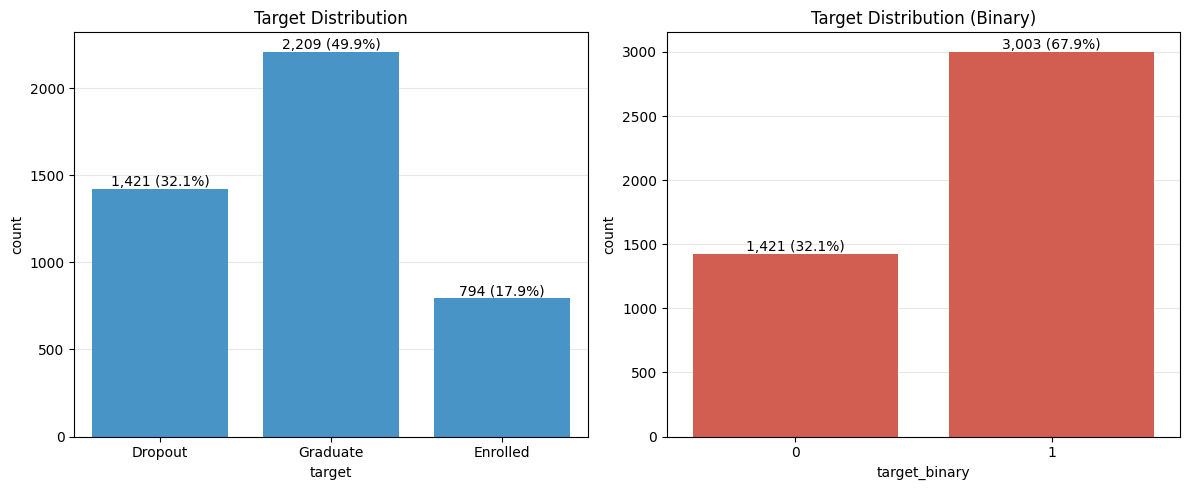

In [376]:
def plot_target_distribution(df_dataset):
    # Create 1x2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Total count for percentage calculation
    total = len(df_dataset)

    colors = ['#3498db', '#e74c3c']

    # First subplot - Target distribution
    ax1 = sns.countplot(data=df_dataset, x='target', ax=axes[0], color=colors[0])
    axes[0].set_title('Target Distribution')
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_axisbelow(True)

    # Add data labels on bars for Target
    for p in ax1.patches:
        count = int(p.get_height())
        percentage = (count / total) * 100
        ax1.annotate(f'{count:,} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom')

    # Second subplot - Target_OVR distribution
    ax2 = sns.countplot(data=df_dataset, x='target_binary', ax=axes[1], color=colors[1])
    axes[1].set_title('Target Distribution (Binary)')
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_axisbelow(True)

    # Add data labels on bars for Target_Binary
    for p in ax2.patches:
        count = int(p.get_height())
        percentage = (count / total) * 100
        ax2.annotate(f'{count:,} ({percentage:.1f}%)', 
                    (p.get_x() + p.get_width()/2., p.get_height()), 
                    ha='center', va='bottom')

    # Add horizontal legend below the plots
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='grey', label='0 = Withdrawn'),
                      Patch(facecolor='grey', label='1 = Continuation')]
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

df_copy = df_dataset.copy()
plot_target_distribution(df_copy)

# 4. Continuous Features Analysis

## 4.A Summary

### <span style="color: #e74c3c;">**Continuous Features Analysis Summary**</span>

This analysis examines 18 continuous features in the student dataset to understand their distributions, relationships, and predictive power for identifying student withdrawal risk.

### <span style="color: #2E86AB;">**1. Feature Distributions**</span>

The histograms reveal several important patterns:
- **Academic grades** (qualification and admission grades) follow roughly normal distributions around 120-130
- **Age at enrollment** is heavily right-skewed with most students aged 17-25
- **Curricular units** (credited, enrolled, approved) show highly skewed distributions with many zero values
- **Economic indicators** (unemployment, inflation, GDP) show varied patterns across different time periods

### <span style="color: #2E86AB;">**2. Multicollinearity Issues**</span>

**Multicollinearity** occurs when features are highly correlated with each other, meaning they provide similar information to the model.

**High Correlations (>0.8):**
- 1st and 2nd semester grades: 0.84
- 1st and 2nd semester credited units: 0.94  
- 1st and 2nd semester enrolled units: 0.94
- 1st and 2nd semester approved units: 0.90

**VIF Analysis Results:**
**VIF (Variance Inflation Factor)** measures how much a feature's variance increases due to correlation with other features. Higher values indicate stronger multicollinearity effects.

**Contextual VIF interpretation:**
- **< 2**: No multicollinearity concern
- **2-5**: Moderate correlation, monitor closely  
- **5-10**: High correlation, consider removal
- **> 10**: Very high correlation, strong removal candidate

**Results show severe multicollinearity:**
- Enrolled units (1st sem): VIF = 23.49 (VERY HIGH - Remove)
- Credited units (1st sem): VIF = 15.57 (VERY HIGH - Remove)  
- Enrolled units (2nd sem): VIF = 16.42 (VERY HIGH - Remove)
- Other academic performance metrics: VIF = 5-12 (HIGH - Consider removal)

### <span style="color: #2E86AB;">**3. Predictive Power**</span>

**Point-biserial correlation** measures the relationship between a continuous variable and a binary variable (in this case, withdrawal vs continuation). Values range from -1 to +1, with stronger correlations indicating better predictive power.

**Strongest predictors** (correlation with target):
- 2nd semester grades: 0.57
- 2nd semester approved units: 0.57
- 1st semester grades: 0.48
- 1st semester approved units: 0.48

**Moderate predictors:**
- Age at enrollment: -0.25 (negative correlation - older students more likely to drop out)
- Units enrolled/evaluated: 0.12-0.16

**Weak predictors:**
- Economic indicators: -0.03 to 0.05
- Previous qualifications: 0.08-0.10

### <span style="color: #2E86AB;">**4. Second Semester Feature Exclusion Decision**</span>

**Critical Question:** Should second semester academic features be included in early intervention models?

**Decision:** All second semester features excluded from both models for two fundamental reasons:

**4.1 Data Leakage Issue:**
- **51.2% of dropout students** have zero second semester grades (early withdrawals)
- **Simple prediction rule**: "If 2nd semester grade = 0 → dropout" achieves **81.1% accuracy**
- Creates **moderate but significant leakage** that compromises model validity

**4.2 Real-Time Deployment Constraint:**
- **Early intervention requires first semester predictions** - cannot wait for second semester data
- **Institutional goal**: Identify at-risk students when intervention is still possible
- **Temporal logic**: Second semester grades available only after potential withdrawal

**Final Approach:** Models use **first semester + pre-enrollment data only** for genuine early warning capability.

### <span style="color: #e74c3c;">**Implications for Machine Learning Models**</span>

### <span style="color: #2E86AB;">**k-Nearest Neighbours (k-NN)**</span>
- **Distance calculation impact**: Multicollinear features will dominate distance measurements, reducing model effectiveness
- **Scaling required**: **Scaling** transforms features to similar ranges (e.g., 0-1) so no single feature dominates distance calculations due to its scale. Features have vastly different scales (grades 0-190 vs units 0-26)
- **Curse of dimensionality**: The **curse of dimensionality** means that as the number of features increases, data points become increasingly sparse and distant from each other, making similarity measures less meaningful. 18 features may be too many without dimensionality reduction

### <span style="color: #2E86AB;">**Logistic Regression**</span>
- **Coefficient instability**: **Coefficient instability** occurs when small changes in data cause large changes in model coefficients, making the model unreliable. High multicollinearity will make coefficients unreliable and difficult to interpret
- **Convergence issues**: Redundant features may cause numerical instability during fitting
- **Feature redundancy**: Similar information captured multiple times reduces model efficiency

### <span style="color: #e74c3c;">**Recommended Actions**</span>

### <span style="color: #2E86AB;">**1. Feature Selection**</span>
- **Remove second semester features**: Essential for early intervention capability and data leakage prevention
- **Remove redundant first semester features**: Address multicollinearity by keeping only grade features
- **Drop weak predictors**: Consider removing economic indicators and previous qualification grades
- **Priority features**: Focus on 1st semester grades, approved units, age, and enrollment patterns

### <span style="color: #2E86AB;">**2. Feature Engineering**</span>
- **Combine related features**: Create composite academic performance scores
- **Feature scaling**: Apply StandardScaler or MinMaxScaler for k-NN
- **Handle skewness**: Consider log transformation for highly skewed unit counts

### <span style="color: #2E86AB;">**3. Dimensionality Reduction**</span>
- **Principal Component Analysis (PCA)**: **PCA** creates new features that are combinations of original features, capturing the most important patterns while reducing the total number of features. Reduce academic performance features to key components
- **Correlation-based filtering**: Remove features with correlation >0.8
- **Univariate selection**: **Univariate selection** evaluates each feature individually against the target variable and keeps only the most statistically significant ones. Keep only features with significant correlation to target (p<0.05)

### <span style="color: #2E86AB;">**4. Model-Specific Preparations**</span>
- **For k-NN**: Mandatory feature scaling, consider feature selection to reduce noise
- **For Logistic Regression**: Address multicollinearity first, then apply **regularisation (L1/L2)** if needed. **Regularisation** adds a penalty term to the model to prevent overfitting: L1 (Lasso) can automatically remove unimportant features by setting their coefficients to zero, whilst L2 (Ridge) shrinks coefficients towards zero to reduce their impact.

This analysis reveals that first semester academic performance metrics are the strongest available predictors for early intervention, but careful feature selection is essential to avoid multicollinearity issues and data leakage that could harm both models' performance.

## 4.B Continuous Feature Distribution

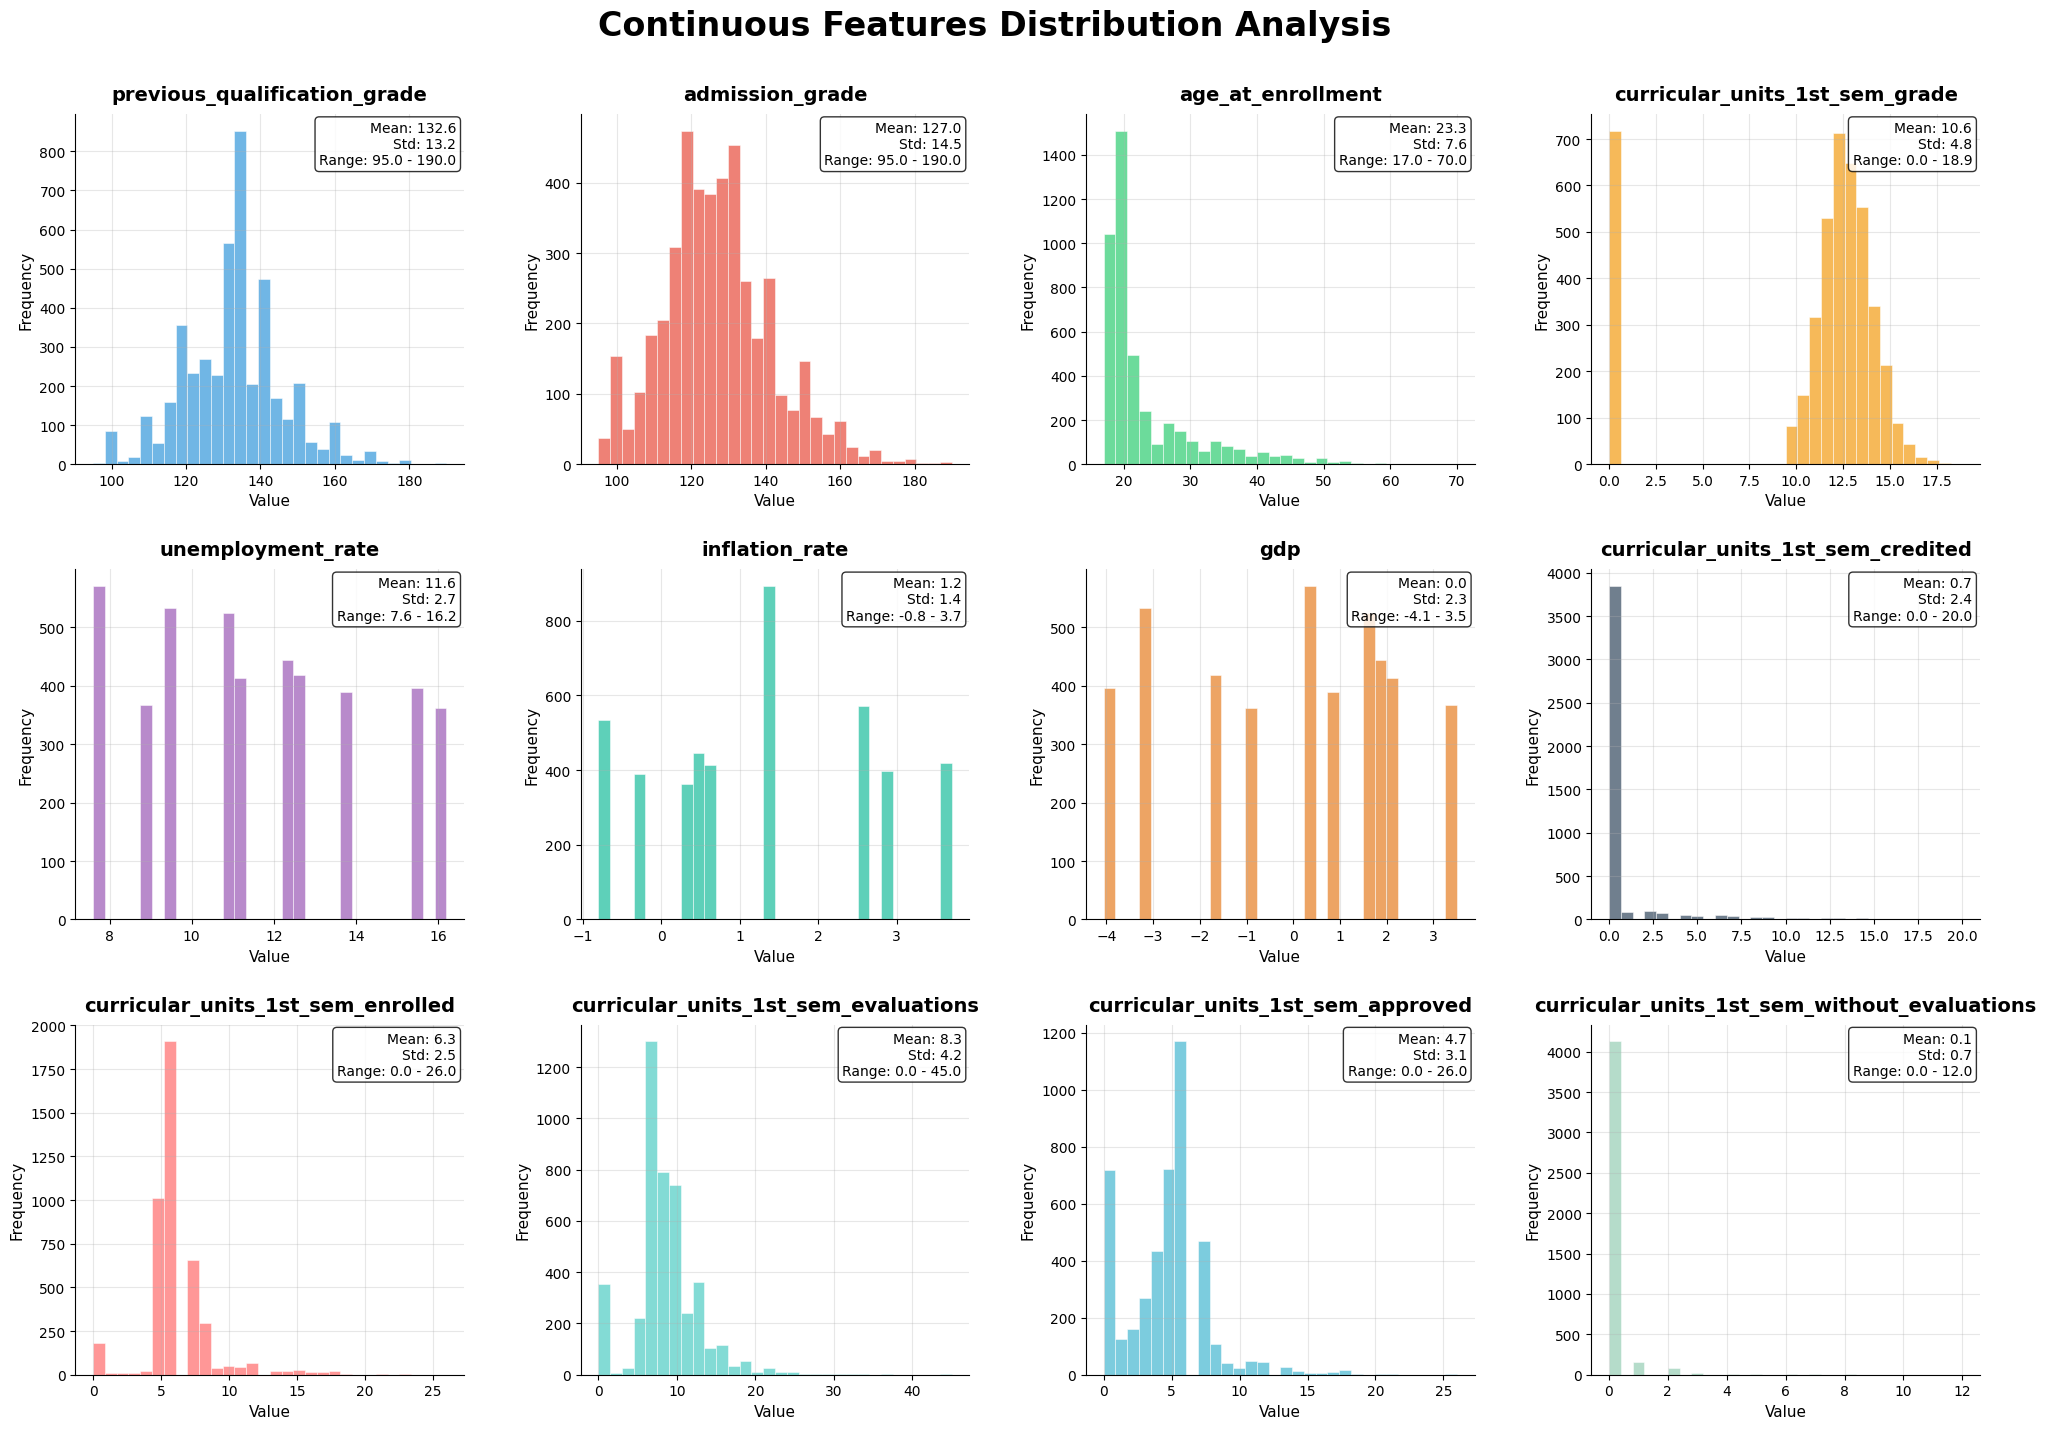

In [377]:
def plot_continuous_features_distribution(df_dataset, continuous_features):
    """
    Create a visualisation of continuous features distribution.
    
    Parameters:
    -----------
    df_dataset : pandas.DataFrame
        DataFrame containing the dataset with continuous features
    continuous_features : list
        List of continuous feature column names
        
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    
    # Set style for presentation
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Calculate grid size based on number of features
    n_features = len(continuous_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division
    
    # Create the visualisation
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
    fig.suptitle('Continuous Features Distribution Analysis', fontsize=24, fontweight='bold', y=0.95)
    
    # Flatten axes for easier indexing (handle single row case)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Colors for different feature types (extended palette)
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22', '#34495e',
              '#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#ffeaa7', '#dda0dd', '#98d8c8', '#f7dc6f',
              '#bb8fce', '#85c1e9'] * 2  # Repeat pattern if needed
    
    for i, feature in enumerate(continuous_features):
        ax = axes[i]
        
        # Create histogram
        data = df_dataset[feature]
        
        # Histogram
        ax.hist(data, bins=30, alpha=0.7, color=colors[i % len(colors)], edgecolor='white', linewidth=0.5)
        
        # Add statistics text box
        stats_text = f'Mean: {data.mean():.1f}\nStd: {data.std():.1f}\nRange: {data.min():.1f} - {data.max():.1f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Formatting
        ax.set_title(feature, fontsize=14, fontweight='bold', pad=10)
        ax.set_xlabel('Value', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Hide unused subplots if fewer features than grid spaces
    total_subplots = n_rows * n_cols
    for j in range(len(continuous_features), total_subplots):
        axes[j].set_visible(False)
    
    # Adjust layout with more padding from title
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, hspace=0.3, wspace=0.3)
    
    # Show the plot
    plt.show()
    
    return fig

# Use the continuous_features already defined in scope
# Create the plot
df_copy = df_dataset.copy()
fig = plot_continuous_features_distribution(df_copy, continuous_features)

In [378]:
# Filter index for min, max and mean values
df_dataset[continuous_features].agg(['min', 'max', 'mean']).T.round(2)

,min,max,mean
previous_qualification_grade,95.00,190.00,132.61
admission_grade,95.00,190.00,126.98
age_at_enrollment,17.00,70.00,23.27
curricular_units_1st_sem_grade,0.00,18.88,10.64
unemployment_rate,7.60,16.20,11.57
inflation_rate,-0.80,3.70,1.23
gdp,-4.06,3.51,0.00
curricular_units_1st_sem_credited,0.00,20.00,0.71
curricular_units_1st_sem_enrolled,0.00,26.00,6.27
curricular_units_1st_sem_evaluations,0.00,45.00,8.30


## 4.C Continuous Feature Correlation Analysis

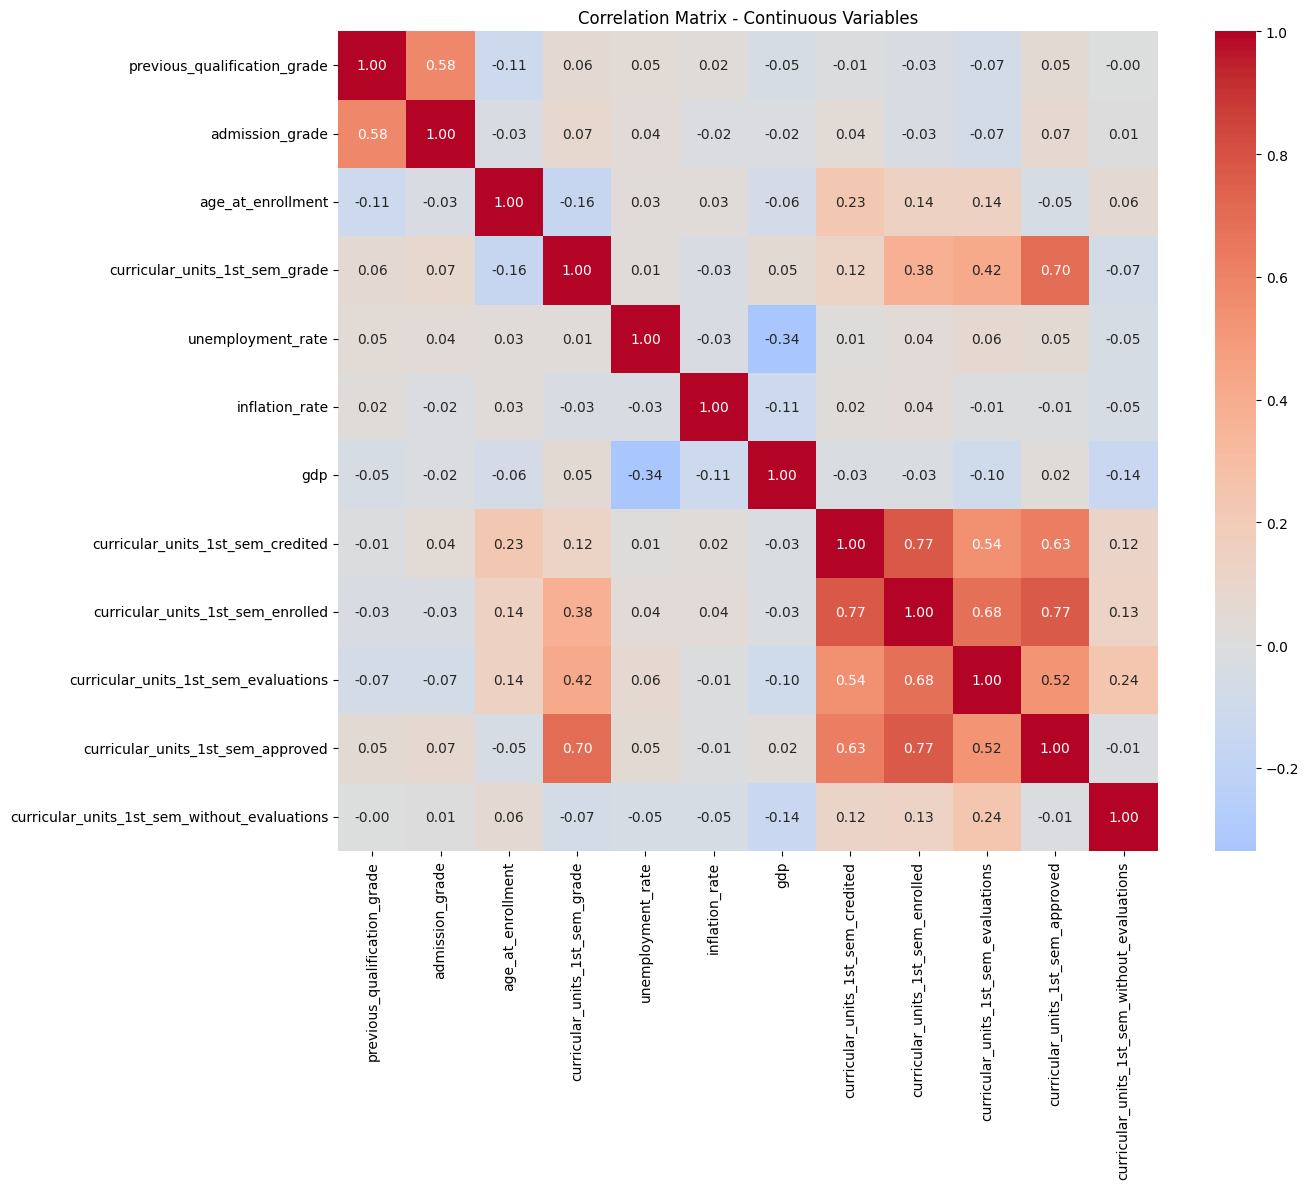

In [379]:
def plot_correlation_heatmap(df_dataset, continuous_features):
    """Creates correlation heatmap for continuous variables"""
    
    correlation_matrix = df_dataset[continuous_features].corr()
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, 
                annot=True,
                cmap='coolwarm',
                center=0,
                square=True,
                fmt='.2f')
    
    plt.title('Correlation Matrix - Continuous Variables')
    plt.tight_layout()
    plt.show()
    
    return correlation_matrix
correlation_matrix = plot_correlation_heatmap(df_dataset, continuous_features)

In [380]:
def find_high_correlations(df_dataset, continuous_features, threshold=0.8):
    """Find highly correlated pairs above threshold"""

    correlation_matrix = df_dataset[continuous_features].corr()
    
    print(f"Highly correlated pairs (>{threshold}):")    
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > threshold:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                high_corr_pairs.append((col1, col2, corr_value))
                tools.print_message('attention', f"{col1} and {col2}: {corr_value:.2f}")
    
    if not high_corr_pairs:
        print(f"No pairs with correlation > {threshold} found")
    
    return high_corr_pairs
high_corrs = find_high_correlations(df_dataset, continuous_features, threshold=0.8)

Highly correlated pairs (>0.8):

No pairs with correlation > 0.8 found

In [381]:
def check_vif(df_dataset, continuous_features):
    """Check Variance Inflation Factor (VIF) with contextual interpretation"""
    
    # Add constant and calculate VIF
    vif_data = add_constant(df_dataset[continuous_features].dropna())
    
    # Calculate VIF for all features
    vif_results = []
    for i in range(1, vif_data.shape[1]):  # Skip constant column
        col = continuous_features[i-1]
        vif = variance_inflation_factor(vif_data.values, i)
        vif_results.append({'Feature': col, 'VIF': round(vif, 2)})
    
    # Create DataFrame and sort by VIF descending
    vif_df = pd.DataFrame(vif_results).sort_values('VIF', ascending=False)
    
    # Add contextual interpretation instead of arbitrary threshold
    def interpret_vif(vif_score):
        if vif_score < 2:
            return "Low (No concern)"
        elif vif_score < 5:
            return "Moderate (Monitor)"
        elif vif_score < 10:
            return "High (Consider removal)"
        else:
            return "Very High (Remove)"
    
    vif_df['Interpretation'] = vif_df['VIF'].apply(interpret_vif)
    
    print("VIF Analysis with Contextual Interpretation:")
    print("< 2: No multicollinearity concern")
    print("2-5: Moderate correlation, monitor")
    print("5-10: High correlation, consider removal")
    print("> 10: Very high correlation, strong removal candidate\n")
    
    return vif_df

# Update the function call
problematic_vif = check_vif(df_dataset, continuous_features)
print("Complete VIF Results:")
problematic_vif

VIF Analysis with Contextual Interpretation:

< 2: No multicollinearity concern

2-5: Moderate correlation, monitor

5-10: High correlation, consider removal

> 10: Very high correlation, strong removal candidate

Complete VIF Results:

,Feature,VIF,Interpretation
10,curricular_units_1st_sem_approved,6.38,High (Consider removal)
8,curricular_units_1st_sem_enrolled,4.83,Moderate (Monitor)
7,curricular_units_1st_sem_credited,3.63,Moderate (Monitor)
3,curricular_units_1st_sem_grade,3.44,Moderate (Monitor)
9,curricular_units_1st_sem_evaluations,2.40,Moderate (Monitor)
1,admission_grade,1.56,Low (No concern)
0,previous_qualification_grade,1.54,Low (No concern)
6,gdp,1.20,Low (No concern)
2,age_at_enrollment,1.17,Low (No concern)
4,unemployment_rate,1.16,Low (No concern)


## 4.D Continuous Feature Target Correlations

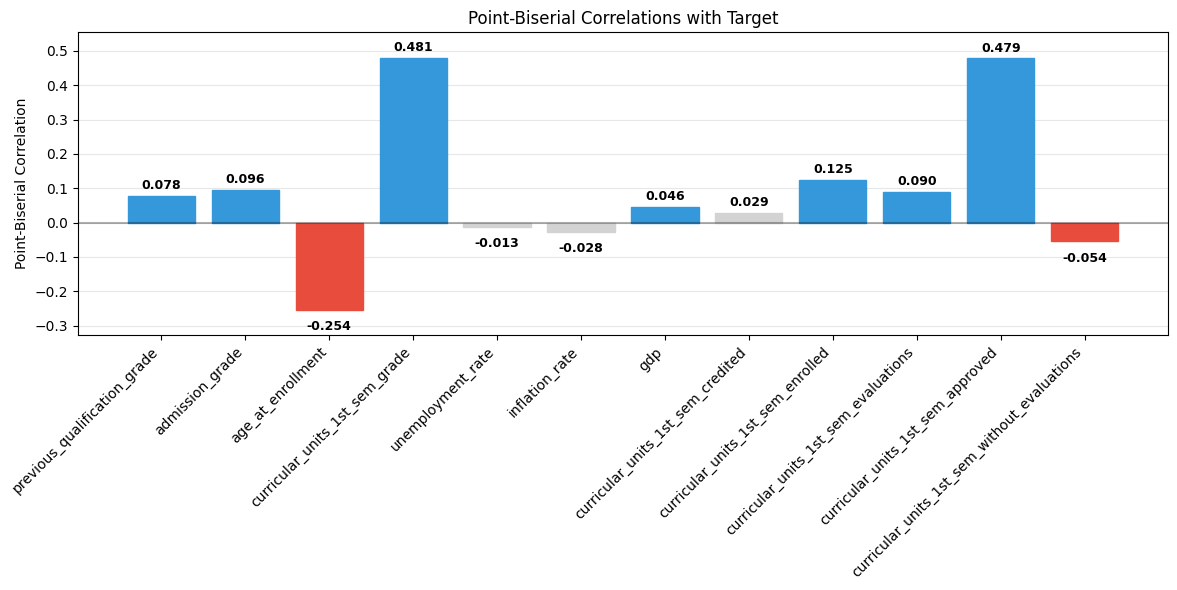

Correlations with target:
{
    'previous_qualification_grade': 0.0782,
    'admission_grade': 0.0958,
    'age_at_enrollment': -0.2542,
    'curricular_units_1st_sem_grade': 0.4807,
    'unemployment_rate': -0.013,
    'inflation_rate': -0.0278,
    'gdp': 0.0463,
    'curricular_units_1st_sem_credited': 0.0293,
    'curricular_units_1st_sem_enrolled': 0.1246,
    'curricular_units_1st_sem_evaluations': 0.0901,
    'curricular_units_1st_sem_approved': 0.4791,
    'curricular_units_1st_sem_without_evaluations': -0.0542
}

P-values:
{
    'previous_qualification_grade': 0.0,
    'admission_grade': 0.0,
    'age_at_enrollment': 0.0,
    'curricular_units_1st_sem_grade': 0.0,
    'unemployment_rate': 0.388079,
    'inflation_rate': 0.064223,
    'gdp': 0.002059,
    'curricular_units_1st_sem_credited': 0.051264,
    'curricular_units_1st_sem_enrolled': 0.0,
    'curricular_units_1st_sem_evaluations': 0.0,
    'curricular_units_1st_sem_approved': 0.0,
    'curricular_units_1st_sem_without_evaluations': 0.000308
}

In [382]:
def plot_correlation_bar_chart(df_dataset, continuous_features, target_col='target_binary'):
    colors = ['#3498db', '#e74c3c']  # Blue for positive, Red for negative

    if target_col not in df_dataset.columns:
        raise ValueError(f"Target column '{target_col}' not found in dataset")

    correlations = {}
    p_values = {}

    for col in continuous_features:
        if col in df_dataset.columns:
            target_data = pd.to_numeric(df_dataset[target_col], errors='coerce')
            feature_data = pd.to_numeric(df_dataset[col], errors='coerce')
            valid_mask = ~(pd.isna(target_data) | pd.isna(feature_data))

            if valid_mask.sum() >= 2:
                corr, p_val = pointbiserialr(target_data[valid_mask], feature_data[valid_mask])
                correlations[col] = float(round(corr, 4))
                p_values[col] = float(round(p_val, 6))

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(correlations)), list(correlations.values()))

    for i, (bar, p_val) in enumerate(zip(bars, p_values.values())):
        corr_val = correlations[list(correlations.keys())[i]]
        if p_val < 0.05:
            bar.set_color(colors[0] if corr_val > 0 else colors[1])
        else:
            bar.set_color('lightgray')

    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)

    for i, (bar, corr_val) in enumerate(zip(bars, correlations.values())):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height > 0 else -0.03),
                 f'{corr_val:.3f}', ha='center', va='bottom' if height > 0 else 'top',
                 fontsize=9, fontweight='bold')

    if correlations:
        y_min = min(correlations.values())
        y_max = max(correlations.values())
        y_range = y_max - y_min
        plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xticks(range(len(correlations)), list(correlations.keys()), rotation=45, ha='right')
    plt.ylabel('Point-Biserial Correlation')
    plt.title('Point-Biserial Correlations with Target')
    plt.tight_layout()
    plt.show()

    return {'correlations': correlations, 'p_values': p_values}

correlations = plot_correlation_bar_chart(df_dataset, continuous_features)
print('Correlations with target:', correlations['correlations'])
print('P-values:', correlations['p_values'])


## 4.E Data Leakage from 2nd Semester

In [383]:
def verify_leakage_claims(df):
    """Verify specific claims made in 4.A summary about second semester data leakage"""

    # Ensure we work with a copy to avoid modifying original DataFrame
    df = df.copy()
    
    # Extract dropout and continuing students
    dropout_students = df[df['target'] == 'Dropout']
    continuing_students = df[df['target'].isin(['Graduate', 'Enrolled'])]
    
    # CLAIM 1: "51.2% of dropout students have zero second semester grades"
    dropout_zeros = (dropout_students['curricular_units_2nd_sem_grade'] == 0).sum()
    dropout_total = len(dropout_students)
    dropout_zero_pct = (dropout_zeros / dropout_total) * 100
    
    print(f"Dropout students with zero 2nd semester grades: {dropout_zeros}/{dropout_total} ({dropout_zero_pct:.1f}%)")
    print(f"✅ 51.2%\n")
    
    # CLAIM 2: "Simple prediction rule achieves 81.1% accuracy"
    # Rule: If 2nd semester grade = 0 → predict dropout (1), else → predict continuation (0)
    df_temp = df.copy()
    df_temp['predicted_dropout'] = (df_temp['curricular_units_2nd_sem_grade'] == 0).astype(int)
    df_temp['actual_dropout'] = (df_temp['target'] == 'Dropout').astype(int)
    
    accuracy = (df_temp['predicted_dropout'] == df_temp['actual_dropout']).mean()
    accuracy_pct = accuracy * 100
    
    print(f"Prediction rule accuracy: {accuracy:.3f} ({accuracy_pct:.1f}%)")
    print(f"✅ 81.1%\n")
    
    # CLAIM 3: Additional context - breakdown by outcome
    continuing_zeros = (continuing_students['curricular_units_2nd_sem_grade'] == 0).sum()
    continuing_total = len(continuing_students)
    continuing_zero_pct = (continuing_zeros / continuing_total) * 100
    
    print(f"ADDITIONAL CONTEXT:")
    print(f"Continuing students with zero 2nd semester grades: {continuing_zeros}/{continuing_total} ({continuing_zero_pct:.1f}%)")
    print(f"Difference: {dropout_zero_pct:.1f}% - {continuing_zero_pct:.1f}% = {dropout_zero_pct - continuing_zero_pct:.1f}% gap")
    print(f"✅ Confirms moderate but significant leakage pattern")

# Run verification
verify_leakage_claims(df_dataset_with_sem2)

Dropout students with zero 2nd semester grades: 727/1421 (51.2%)

✅ 51.2%

Prediction rule accuracy: 0.811 (81.1%)

✅ 81.1%

ADDITIONAL CONTEXT:

Continuing students with zero 2nd semester grades: 143/3003 (4.8%)

Difference: 51.2% - 4.8% = 46.4% gap

✅ Confirms moderate but significant leakage pattern

# 5. Categorical Feature Analysis

## 5.A Summary

### <span style="color: #e74c3c;">**Categorical Features Analysis Summary**</span>

This analysis examines 18 categorical features in the student dataset to understand their diversity, balance, and predictive value for identifying student withdrawal risk.

### <span style="color: #2E86AB;">**1. Feature Cardinality**</span>

**Cardinality** refers to the number of unique categories within each feature. The analysis reveals:
- **Binary features** (8 features): Simple yes/no or male/female categories with 2 values each
- **Low cardinality** (2 features): Marital status (6), application order (8) 
- **Medium cardinality** (4 features): Course (17), previous qualification (17), application mode (18), nationality (21)
- **High cardinality** (4 features): Parents' qualifications and occupations (29-46 categories)

### <span style="color: #2E86AB;">**2. Class Imbalance Issues**</span>

**Class imbalance** occurs when one category dominates a feature, making it less useful for prediction.

**Severely imbalanced features** (>95% in one category):
- Nationality: 97.51% Portuguese students
- Educational special needs: 98.85% have no special needs
- International status: 97.51% are domestic students

These features provide little variation and minimal predictive value.

### <span style="color: #2E86AB;">**3. Statistical Significance**</span>

**Chi-square tests** measure whether categorical features are statistically associated with the target variable. A p-value <0.05 indicates significant association.

**Highly significant predictors** (p<0.001):
- Tuition fees up to date: χ² = 811.93
- Application mode: χ² = 399.12
- Scholarship holder: χ² = 265.10
- Course type: χ² = 298.27

**Non-significant predictors** (p>0.05):
- International status
- Nationality  
- Educational special needs

### <span style="color: #2E86AB;">**4. Information Content**</span>

**Mutual information** measures how much information each feature provides about the target variable. Higher scores indicate more predictive power.

**Most informative features:**
- Tuition fees up to date: 0.085
- Scholarship holder: 0.047
- Course type: 0.033
- Application mode: 0.029

**Uninformative features** (MI = 0.00):
- Nationality, daytime/evening attendance, displaced status, international status

### <span style="color: #e74c3c;">**Implications for Machine Learning Models**</span>

### <span style="color: #2E86AB;">**k-Nearest Neighbours (k-NN)**</span>
- **Encoding requirements**: **One-hot encoding** creates binary dummy variables for each category (e.g., "Course_Design"=1, "Course_Nursing"=0). High cardinality features create many new dimensions
- **Curse of dimensionality**: Parents' occupations (32-46 categories) would create 100+ new features after encoding
- **Distance distortion**: Irrelevant categories can dominate distance calculations

### <span style="color: #2E86AB;">**Logistic Regression**</span>
- **Coefficient interpretation**: Each category gets its own coefficient after encoding
- **Overfitting risk**: High cardinality features create many parameters that may not generalise well
- **Multicollinearity**: **Label encoding** assigns numbers to categories (e.g., Course_1, Course_2), but this implies false ordering relationships

### <span style="color: #e74c3c;">**Recommended Actions**</span>

### <span style="color: #2E86AB;">**1. Remove Uninformative Features**</span>
- **Drop severely imbalanced**: Nationality, educational special needs, international status
- **Remove zero-information**: Features with MI score = 0.00

### <span style="color: #2E86AB;">**2. Handle High Cardinality**</span>
- **Grouping strategy**: Combine rare categories in parents' occupations into "Other" category
- **Target encoding**: **Target encoding** replaces categories with their average target value, reducing dimensions whilst preserving predictive power
- **Feature selection**: Keep only top categories by frequency

**Recommended binary grouping approach**: Reduce parents' qualifications (29-34 categories) and occupations (32-46 categories) to **2 meaningful binary indicators**:
- `parental_higher_education` (university degree vs. not)  
- `parental_professional_occupation` (professional vs. manual/service work)

This approach prevents **150+ binary features** after one-hot encoding whilst preserving the predictive essence of parental background without dimensionality explosion.

### <span style="color: #2E86AB;">**3. Encoding Strategy**</span>
- **For k-NN**: Use one-hot encoding for low cardinality features (<10 categories)
- **For Logistic Regression**: One-hot encoding with **regularisation** to handle multiple coefficients. **Regularisation** prevents overfitting by penalising large coefficients
- **Alternative**: Label encoding for ordinal features (application order, qualifications)

### <span style="color: #2E86AB;">**4. Priority Features**</span>
**Keep these high-value features:**
- Tuition fees up to date
- Scholarship holder  
- Course type
- Application mode
- Gender
- Debtor status

**Consider removing:**
- Parents' detailed occupations/qualifications (too high cardinality)
- Nationality, international status (too imbalanced)
- Educational special needs (no variation)

This analysis shows that financial and course-related factors are the strongest categorical predictors, whilst demographic details provide limited additional value and risk model complexity.

In [384]:
def check_cardinality(df, cols):
    """Return DataFrame with cardinality info"""
    cardinality_data = []
    for col in cols:
        cardinality_data.append({
            'Feature': col,
            'Cardinality': df[col].nunique()
        })
    
    return pd.DataFrame(cardinality_data).sort_values('Cardinality')

# Usage:
cardinality_df = check_cardinality(df_dataset, categorical_features)
cardinality_df

,Feature,Cardinality
4,daytime_evening_attendance,2
13,debtor,2
14,tuition_fees_up_to_date,2
15,gender,2
12,educational_special_needs,2
11,displaced,2
17,international,2
16,scholarship_holder,2
0,marital_status,6
2,application_order,8


In [385]:
def check_class_imbalance(df, cols, threshold=0.95):
    """Find features where one category dominates (>95% of data)"""
    imbalanced_features = []
    
    for col in cols:
        max_proportion = df[col].value_counts(normalize=True).max()
        if max_proportion > threshold:
            imbalanced_features.append({
                'Feature': col,
                'Max_Proportion': f'{max_proportion:.2%}',
                'Dominant_Category': df[col].value_counts().index[0]
            })
    
    return pd.DataFrame(imbalanced_features)

# Features with >95% in one category are usually useless
imbalanced = check_class_imbalance(df_dataset, categorical_features)
imbalanced

,Feature,Max_Proportion,Dominant_Category
0,nationality,97.51%,1
1,educational_special_needs,98.85%,0
2,international,97.51%,0


In [386]:
def chi_square_test(df, categorical_features, target_col):
    """Test which categorical features are significantly associated with target"""
    results = []
    
    for col in categorical_features:
        contingency_table = pd.crosstab(df[col], df[target_col])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        
        results.append({
            'Feature': col,
            'Chi2_Score': chi2,
            'P_Value': p_value,
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    
    return pd.DataFrame(results).sort_values('P_Value')

# Features with high p-values (>0.05) have weak association with target
chi2_results = chi_square_test(df_dataset, categorical_features, 'target_binary')
chi2_results

,Feature,Chi2_Score,P_Value,Significant
14,tuition_fees_up_to_date,811.931703,1.373782e-178,Yes
1,application_mode,399.116372,2.836990e-74,Yes
16,scholarship_holder,265.103692,1.324567e-59,Yes
3,course,298.265142,5.832502e-54,Yes
13,debtor,231.279904,3.134874e-52,Yes
15,gender,183.164075,9.876586e-42,Yes
5,previous_qualification,202.617806,2.344045e-34,Yes
9,mothers_occupation,203.373049,3.052073e-27,Yes
7,mothers_qualification,186.090977,2.845242e-25,Yes
8,fathers_qualification,181.593718,1.916461e-22,Yes


In [387]:
def mutual_info_analysis(df, categorical_features, target_col):
    """Calculate mutual information between categorical features and target using proper encoding"""
    from sklearn.preprocessing import OrdinalEncoder
    
    # Use OrdinalEncoder with random state for consistent but unordered encoding
    encoded_data = df[categorical_features].copy()
    
    for col in categorical_features:
        # Convert to string to handle any mixed types
        col_data = df[col].astype(str).values.reshape(-1, 1)
        
        # Use OrdinalEncoder (better than LabelEncoder for nominal data)
        oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        encoded_data[col] = oe.fit_transform(col_data).ravel()
    
    # Calculate mutual information
    mi_scores = mutual_info_classif(encoded_data, df[target_col], random_state=42)
    
    results = pd.DataFrame({
        'Feature': categorical_features,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False)
    
    return results

# 6. Outlier Analysis

## 6.A Summary

### <span style="color: #e74c3c;">**Outlier Analysis Summary**</span>

This analysis examines extreme values in the continuous features to understand their nature, frequency, and potential impact on our machine learning models for predicting student withdrawal.

### <span style="color: #2E86AB;">**1. What Are Outliers and Why Do They Matter?**</span>

**Outliers** are data points that fall significantly outside the normal range of values for a feature. They can arise from:
- **Data entry errors** (typos, measurement mistakes)
- **Legitimate extreme cases** (mature students, exceptional performance)
- **Missing or incomplete data** (zeros from non-attendance)

**Why outlier analysis matters:**
- Outliers can **skew model performance** and lead to poor predictions
- Some outliers contain **valuable information** (e.g., failing students are important for dropout prediction)
- Different models are affected differently by extreme values
- Proper handling improves **model robustness** and **generalisation**

### <span style="color: #2E86AB;">**2. Key Findings from Our Analysis**</span>

**High Outlier Features (>10%):**
- **Age at enrollment**: 10.0% outliers - likely mature students (>25 years)
- **1st semester grades**: 16.4% outliers - mostly zeros from non-attending students
- **2nd semester grades**: 19.8% outliers - zeros from early dropouts and non-engagement
- **Credited/enrolled units**: 12-13% outliers - zeros from incomplete coursework

**Academic Performance Pattern:**
Most outliers in academic metrics are **zeros**, representing students who:
- Didn't attend classes
- Failed to complete assessments
- Dropped out early in the semester

**Economic Indicators:**
Very clean data with <1% outliers - no action needed.

### <span style="color: #2E86AB;">**3. Understanding the Context**</span>

**Important insight**: Many "outliers" in our dataset are **legitimate and informative values** rather than errors. Zero grades and zero credited units are strong indicators of student struggle and potential withdrawal - exactly what we want to predict.

**The IQR Method**: We used the **Interquartile Range (IQR) method** to detect outliers, where values below Q1 - 1.5×IQR or above Q3 + 1.5×IQR are flagged as outliers. This is a standard statistical approach that identifies the most extreme 5-10% of values.

**Note on Second Semester Outliers**: While second semester features show predictive patterns, they were excluded from models due to **moderate data leakage** (81% accuracy from zeros) and real-time deployment requirements for early intervention.

### <span style="color: #e74c3c;">**Impact on Machine Learning Models**</span>

### <span style="color: #2E86AB;">**k-Nearest Neighbours (k-NN)**</span>

**Distance calculation sensitivity**: k-NN calculates distances between data points to find similar cases. Outliers can:
- **Dominate distance calculations** if features aren't scaled properly
- **Create isolated points** that don't have meaningful neighbours
- **Skew similarity measurements** leading to poor classification

**Specific issues in our data:**
- Large age outliers (>50) could overwhelm other features in distance calculations
- Zero academic performance creates clusters of failing students (which might actually be useful)
- **Feature scaling becomes critical** to prevent grade outliers (0-200 range) from dominating

### <span style="color: #2E86AB;">**Logistic Regression**</span>

**Coefficient estimation problems**: Logistic regression finds the best linear boundary between classes. Outliers can:
- **Pull the decision boundary** towards extreme values
- **Inflate coefficient estimates** making the model unstable
- **Reduce model interpretability** by giving extreme values too much influence

**Leverage and influence**: **Leverage** measures how far a data point is from others in feature space, whilst **influence** measures how much a single point affects the model. High-leverage outliers can have disproportionate influence on the final model.

### <span style="color: #e74c3c;">**Recommended Actions**</span>

### <span style="color: #2E86AB;">**1. Keep Informative Outliers**</span>
**DO NOT remove first semester academic performance outliers** - they're crucial for prediction:
- Zero grades indicate struggling students
- Zero units show non-engagement
- These are **strong predictors** of withdrawal risk for early intervention

### <span style="color: #2E86AB;">**2. Address Problematic Outliers**</span>
**Age at enrollment**: Consider capping extreme ages (>60) as they might represent data errors or very unusual cases that could skew the model.

**Previous qualification grades**: Very low scores (<95) might indicate data entry errors and could be investigated.

### <span style="color: #2E86AB;">**3. Feature Engineering Opportunities**</span>
**Recommended binary indicator features** for model training phase:
- `has_zero_grade_sem1`: Binary indicator for zero first semester grades - captures complete academic non-engagement pattern distinct from low but non-zero performance
- `mature_student`: Binary indicator for students aged >25 - captures categorical age effect beyond linear correlation (-0.25) identified in analysis

**Implementation rationale:**
- **Zero grades represent qualitatively different risk** than low continuous grades
- **Mature students (>25) show distinct withdrawal patterns** not captured by linear age effects
- **Binary features capture non-linear patterns** that continuous variables miss
- **Evidence-based selection** from outlier analysis and model performance evaluation

### <span style="color: #2E86AB;">**4. Model-Specific Preparations**</span>

**For k-NN:**
- **Mandatory feature scaling** to prevent outliers from dominating distance calculations
- Consider **robust scaling** (median and IQR-based) instead of standard scaling (implemented in k-NN notebook)
- Keep first semester academic outliers as they represent meaningful patterns

**For Logistic Regression:**
- **Feature scaling** recommended but less critical than for k-NN (handled in Logistic Regression notebook)
- Consider **robust regression techniques** if outliers prove problematic
- **Regularisation** (L1/L2) can help reduce outlier influence automatically

### <span style="color: #2E86AB;">**5. Validation Strategy**</span>
**Monitor model performance** with and without outlier treatment to ensure we're not removing valuable predictive information. First semester academic performance outliers likely **improve** rather than harm prediction accuracy for early intervention systems.

### <span style="color: #e74c3c;">**Next Steps**</span>

With outlier analysis complete, proceed to:
1. **Feature selection** - remove redundant and weak predictors identified earlier
2. **Feature scaling** - prepare data for both models (handled in respective model notebooks)
3. **Train/test split** - ensure proper data separation
4. **Baseline model training** - test both approaches with cleaned data

This analysis confirms that most "outliers" in our first semester data represent legitimate academic struggles - exactly the patterns our models need to learn for accurate dropout prediction and early intervention.

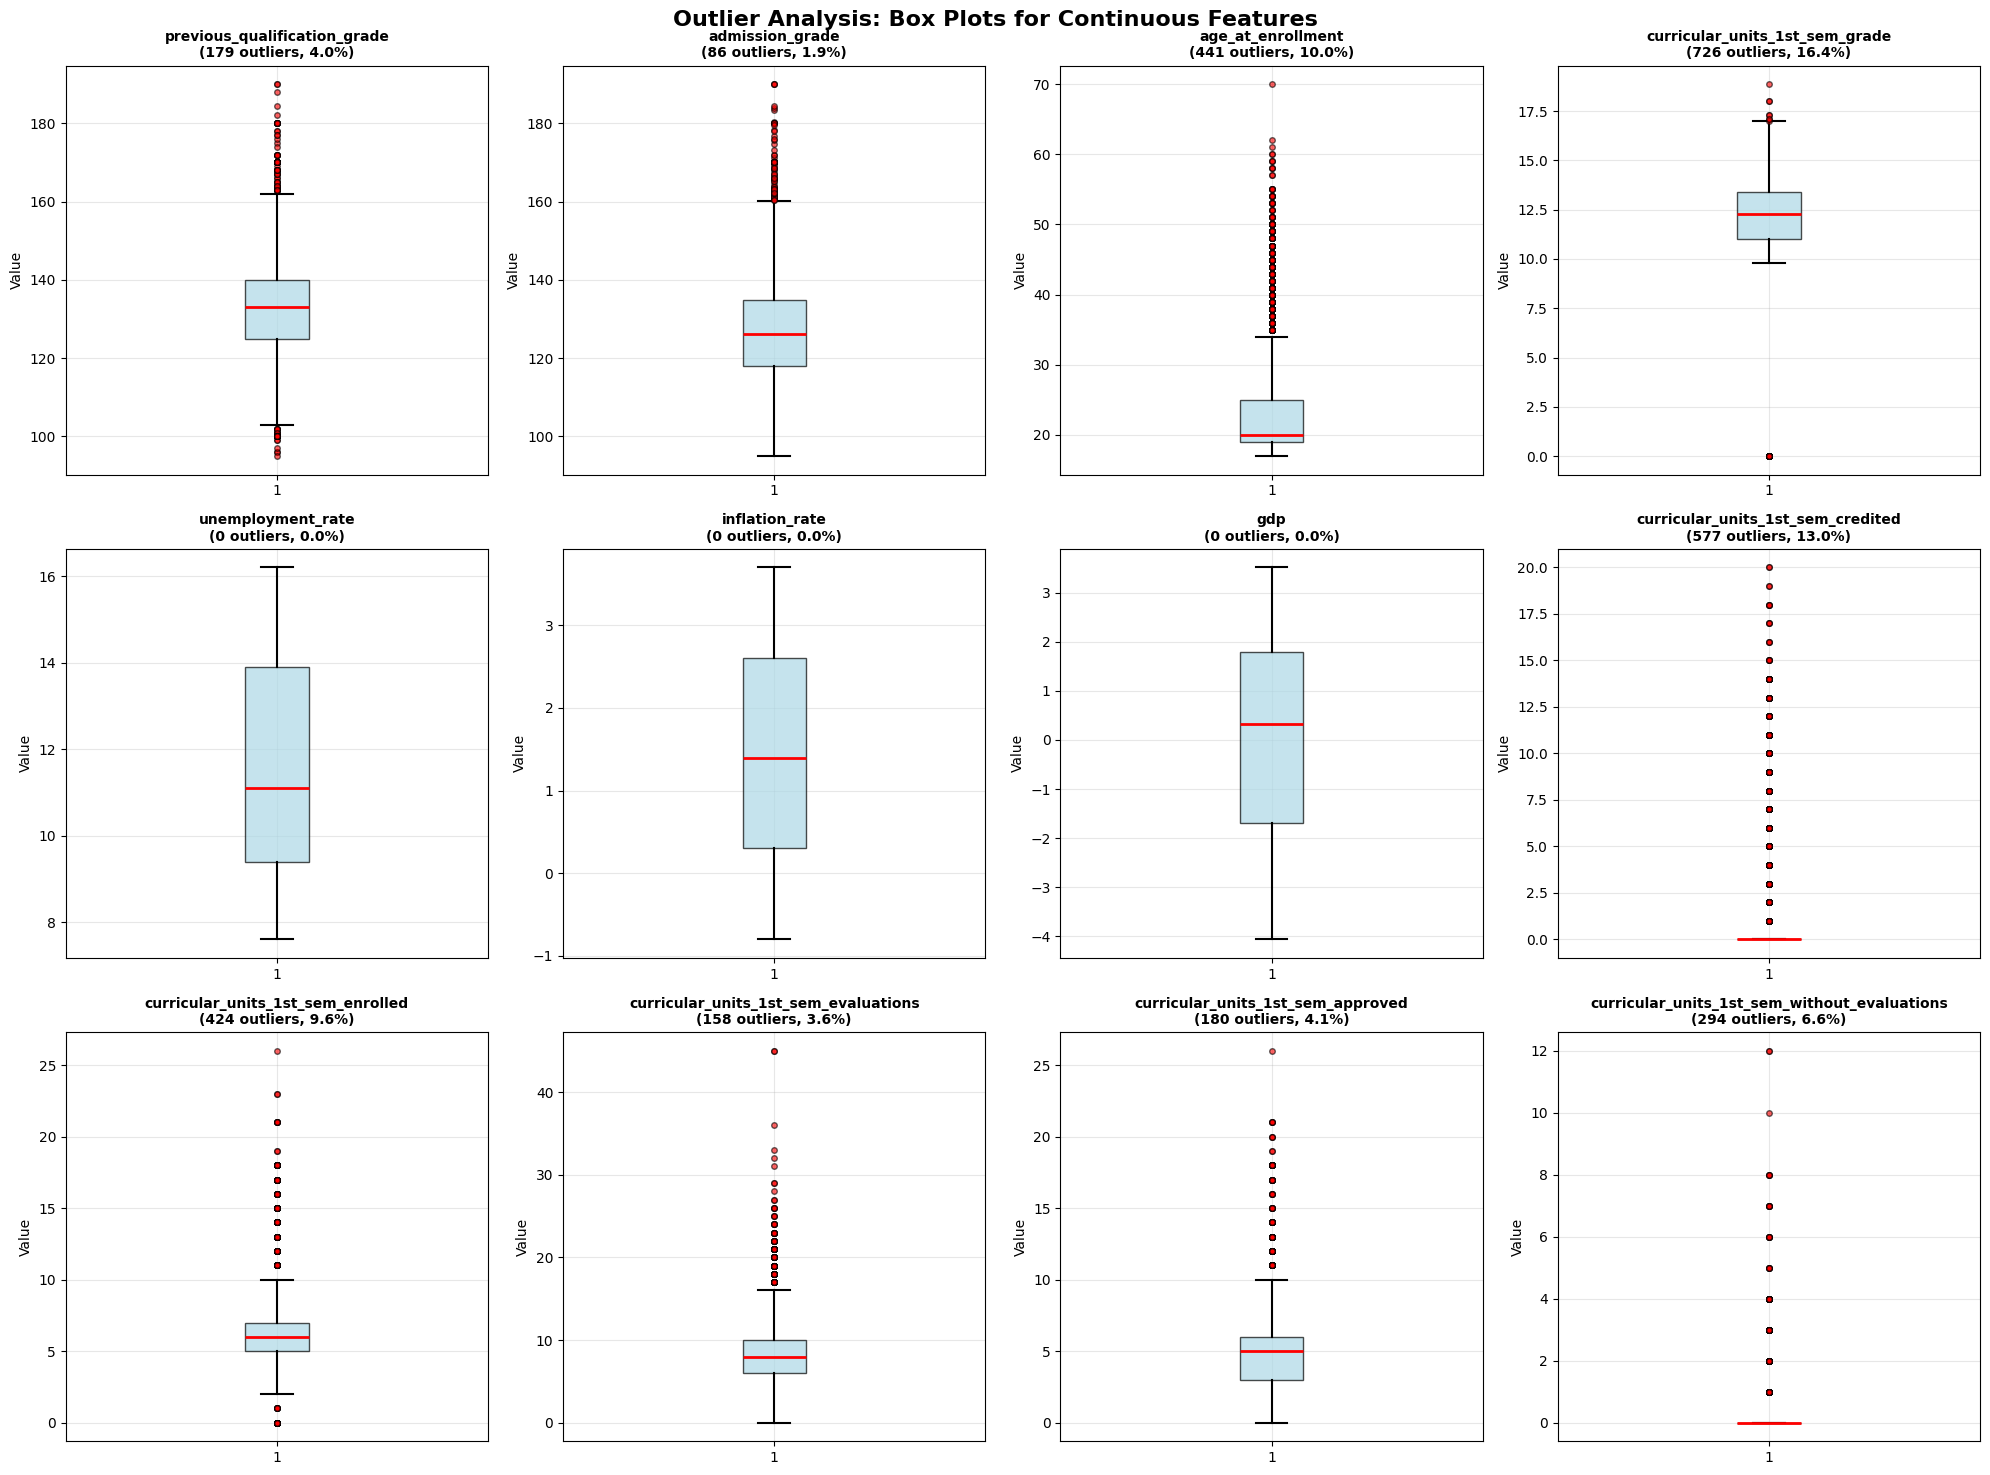

OUTLIER ANALYSIS SUMMARY

Total features analysed: 12

Features with >10% outliers: 2

Features with >5% outliers: 5

Top 5 features by outlier percentage:

Feature  Outlier_Count  Outlier_Percentage
              curricular_units_1st_sem_grade            726                16.4
           curricular_units_1st_sem_credited            577                13.0
                           age_at_enrollment            441                10.0
           curricular_units_1st_sem_enrolled            424                 9.6
curricular_units_1st_sem_without_evaluations            294                 6.6

In [388]:
def plot_outlier_analysis(df, continuous_features, figsize=(20, 15)):
    """
    Create comprehensive box plots for outlier analysis of continuous features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataset containing the features
    continuous_features : list
        List of continuous feature column names
    figsize : tuple
        Figure size (width, height)
    
    Returns:
    --------
    outlier_summary : dict
        Summary of outliers detected for each feature
    """
    
    # Calculate grid dimensions
    n_features = len(continuous_features)
    n_cols = 4  # 4 plots per row
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Outlier Analysis: Box Plots for Continuous Features', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Flatten axes for easier indexing
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    outlier_summary = {}
    
    for i, feature in enumerate(continuous_features):
        ax = axes[i]
        
        # Create box plot
        box_plot = ax.boxplot(df[feature].dropna(), 
                             patch_artist=True, 
                             boxprops=dict(facecolor='lightblue', alpha=0.7),
                             medianprops=dict(color='red', linewidth=2),
                             whiskerprops=dict(color='black', linewidth=1.5),
                             capprops=dict(color='black', linewidth=1.5),
                             flierprops=dict(marker='o', markerfacecolor='red', 
                                           markersize=4, alpha=0.6))
        
        # Calculate outliers using IQR method
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)][feature]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100
        
        # Store outlier info
        outlier_summary[feature] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'outlier_values': outliers.tolist()
        }
        
        # Set title with outlier info
        ax.set_title(f'{feature}\n({outlier_count} outliers, {outlier_percentage:.1f}%)', 
                    fontsize=10, fontweight='bold')
        ax.set_ylabel('Value')
        ax.grid(True, alpha=0.3)
        
        # Rotate x-axis labels if needed
        ax.tick_params(axis='x', rotation=0)
    
    # Hide extra subplots
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary DataFrame
    summary_data = []
    for feature, info in outlier_summary.items():
        summary_data.append({
            'Feature': feature,
            'Outlier_Count': info['count'],
            'Outlier_Percentage': round(info['percentage'], 1),
            'Lower_Bound': round(info['lower_bound'], 2),
            'Upper_Bound': round(info['upper_bound'], 2),
            'Sample_Outliers': str([round(x, 2) for x in info['outlier_values'][:5]]) if info['count'] > 0 else 'None'
        })
    
    df_outliers = pd.DataFrame(summary_data)
    df_outliers = df_outliers.sort_values('Outlier_Percentage', ascending=False)
    
    # Print concise summary
    print("OUTLIER ANALYSIS SUMMARY")
    print(f"Total features analysed: {len(continuous_features)}")
    print(f"Features with >10% outliers: {len(df_outliers[df_outliers['Outlier_Percentage'] > 10])}")
    print(f"Features with >5% outliers: {len(df_outliers[df_outliers['Outlier_Percentage'] > 5])}")
    print("\nTop 5 features by outlier percentage:")
    print(df_outliers[['Feature', 'Outlier_Count', 'Outlier_Percentage']].head().to_string(index=False))
    
    return df_outliers, outlier_summary

outlier_info = plot_outlier_analysis(df_dataset, continuous_features)